NYSERDA sample project

In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# import data
file_path = 'data/LL87_2019-2024.xlsx'
df = pd.read_excel(file_path)

print(df.head())

   Property ID  Audit Template ID             Property Name  Borough  \
0          128                505        2 West 67th Street     1.00   
1          148                584        105-05 69th Avenue     4.00   
2          165                607            17 W 17 Street     1.00   
3          185                636      350 West 31st Street     1.00   
4          189                642  Two United Nations Plaza     1.00   

   Tax Block  Tax Lot Borough/Block/Lot (BBL)  Number of Buildings on Lot EER  \
0       1119       36            1-01119-0036                           1   A   
1       2139        1            4-02139-0001                           1   A   
2        819       27            1-00819-0027                           1   A   
3        754       68            1-00754-0068                           1   A   
4       1337       14            1-01337-0014                           1   A   

       Submission Date  ...  Total Cost Savings ($) Total Peak Demand Savings  \

In [15]:
# Turn off scientific notation globally
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [16]:
# Build list of dataframes for each package and fuel
dfs_list = []

for pkg in [1, 2, 3, 4]:
    for fuel in [1, 2, 3, 4, 5]:
        # Aggregate measure cost across all ECMs for this package
        total_measure_cost = sum([
            pd.to_numeric(df[f"Measure Cost ($): Package {pkg}-ECM {ecm}"], errors='coerce').fillna(0)
            for ecm in [1, 2, 3]
        ])
        
        # Create list of measure categories across all ECMs for this package
        measure_categories = [
            df[f"Measure Category: Package {pkg}-ECM {ecm}"].values
            for ecm in [1, 2, 3]
        ]
        
        temp_df = pd.DataFrame({
            'Property_ID': df["Property ID"].values,
            'Audit_Date': df['Date of Completion for Level 2 Audit'].values,
            'Package_Category': df[f"Package Category: Package {pkg}"].values,
            'Package': pkg,
            'Fuel': fuel,
            'Fuel_Type': df[f"Annual Fuel {fuel} Energy Type: Package {pkg}"].values,
            'Annual_Savings': pd.to_numeric(df[f"Annual Fuel {fuel} Savings: Package {pkg}"], errors='coerce'),
            'Measure_Cost': total_measure_cost,
            'Measure_Categories_ECM1': measure_categories[0],
            'Measure_Categories_ECM2': measure_categories[1],
            'Measure_Categories_ECM3': measure_categories[2]
        })
        dfs_list.append(temp_df)

# Combine all packages and fuels
long_df = pd.concat(dfs_list, ignore_index=True)

In [17]:
# Create boolean mask for filtering
mask = (
    (long_df['Fuel_Type'] == 'Electricity') & # only keep electricity rows
    (long_df['Annual_Savings'].notna()) & # remove NA savings
    (long_df['Annual_Savings'] != 0) & # remove zero savings
    (long_df['Measure_Cost'].notna()) & # remove NA costs
    (long_df['Measure_Cost'] != 0) & # remove zero costs
    (long_df['Measure_Categories_ECM2'].isna()) & # only keep rows where ECM2 is NA
    (long_df['Measure_Categories_ECM3'].isna()) # only keep rows where ECM3 is NA
)

# Filter rows
electricity_df = long_df.loc[mask].copy()

# Create new column
electricity_df.loc[:, 'Savings_per_Cost'] = electricity_df['Annual_Savings'] / electricity_df['Measure_Cost']

# Split into two dataframes
low_cost_df = electricity_df.loc[electricity_df['Package_Category'] == 'Low Cost and No Cost Recommendations']
high_cost_df = electricity_df.loc[electricity_df['Package_Category'] != 'Low Cost and No Cost Recommendations']

# Check lengths
len(low_cost_df), len(high_cost_df), len(low_cost_df) + len(high_cost_df), len(electricity_df)

(6388, 8698, 15086, 15086)

In [18]:
electricity_df.head()

,Property_ID,Audit_Date,Package_Category,Package,Fuel,Fuel_Type,Annual_Savings,Measure_Cost,Measure_Categories_ECM1,Measure_Categories_ECM2,Measure_Categories_ECM3,Savings_per_Cost
1,148,2018-09-27,Low Cost and No Cost Recommendations,1,1,Electricity,7460.00,910.00,Lighting Improvements,NaN,NaN,8.20
2,165,2018-04-01,Low Cost and No Cost Recommendations,1,1,Electricity,786.00,1000.00,Lighting Improvements,NaN,NaN,0.79
3,185,2018-08-03,Low Cost and No Cost Recommendations,1,1,Electricity,50176.00,30500.00,Lighting Improvements,NaN,NaN,1.65
4,189,2016-10-24,Low Cost and No Cost Recommendations,1,1,Electricity,51118.00,21600.00,Chilled Water; Hot Water; and Steam Distributi...,NaN,NaN,2.37
5,194,2015-09-03,Potential Capital Recommendations,1,1,Electricity,38113.00,15800.00,Lighting Improvements,NaN,NaN,2.41


<Figure size 1200x800 with 0 Axes>

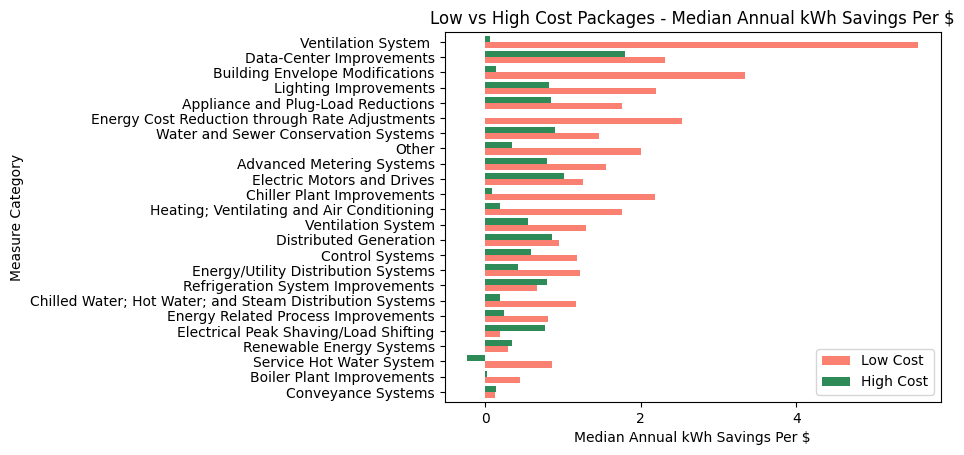

In [19]:
# Aggregate by measure category
low_cost_savings = low_cost_df.groupby('Measure_Categories_ECM1')['Savings_per_Cost'].median()
high_cost_savings = high_cost_df.groupby('Measure_Categories_ECM1')['Savings_per_Cost'].median()

# Combine into one dataframe
combined_df = pd.DataFrame({
    'Low Cost': low_cost_savings,
    'High Cost': high_cost_savings
}).fillna(0)

# Remove 'Uncategorized' row
combined_df = combined_df[combined_df.index != 'Uncategorized']

# Sort by total (sum of both)
combined_df['Total'] = combined_df['Low Cost'] + combined_df['High Cost']
combined_df = combined_df.sort_values('Total')
combined_df = combined_df.drop('Total', axis=1)

# Create grouped bar chart
plt.figure(figsize=(12, 8))
ax = combined_df.plot(kind='barh', color=['salmon', 'seagreen'], width=0.8)

# Reduce number of ticks
ax.locator_params(axis='x', nbins=6)

plt.title('Low vs High Cost Packages - Median Annual kWh Savings Per $', loc='center')
plt.xlabel('Median Annual kWh Savings Per $', loc='center')
plt.ylabel('Measure Category')
plt.legend(loc='lower right')

#plt.tight_layout()
plt.show()

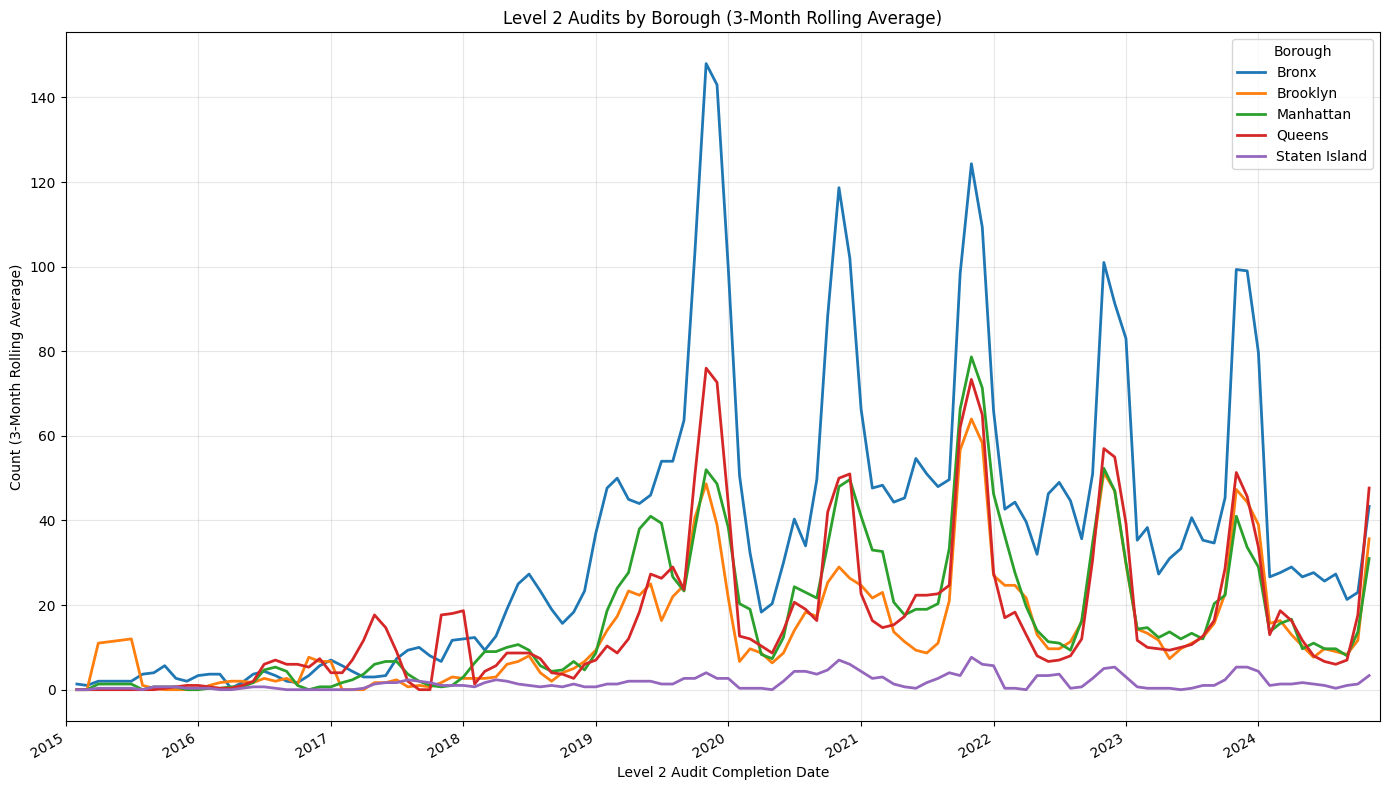

In [20]:
import matplotlib.dates as mdates

# Borough mapping
borough_map = {
    1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island',
    1.0: 'Bronx', 2.0: 'Brooklyn', 3.0: 'Manhattan', 4.0: 'Queens', 5.0: 'Staten Island',
    '1': 'Bronx', '2': 'Brooklyn', '3': 'Manhattan', '4': 'Queens', '5': 'Staten Island'
}

# Convert date column
df['Date of Completion for Level 2 Audit'] = pd.to_datetime(
    df['Date of Completion for Level 2 Audit'], errors='coerce'
)

# Map borough numbers to names and filter
valid_df = df[['Date of Completion for Level 2 Audit', 'Borough']].dropna()
valid_df = valid_df[valid_df['Date of Completion for Level 2 Audit'].dt.year >= 2015].copy()
valid_df['Borough'] = valid_df['Borough'].map(borough_map)
valid_df['Year_Month'] = valid_df['Date of Completion for Level 2 Audit'].dt.to_period('M')

# Aggregate and pivot
borough_over_time = valid_df.groupby(['Year_Month', 'Borough']).size().reset_index(name='Count')
borough_pivot = borough_over_time.pivot(index='Year_Month', columns='Borough', values='Count').fillna(0)
borough_pivot.index = borough_pivot.index.to_timestamp()

# Apply smoothing
borough_pivot_smoothed = borough_pivot.rolling(window=3, center=True).mean()

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
borough_pivot_smoothed.plot(kind='line', ax=ax, linewidth=2)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(borough_pivot.index.min(), borough_pivot.index.max())

plt.title('Level 2 Audits by Borough (3-Month Rolling Average)', loc='center')
plt.xlabel('Level 2 Audit Completion Date')
plt.ylabel('Count (3-Month Rolling Average)')
plt.legend(title='Borough')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()